In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import skbio

import asd
%matplotlib inline

In [2]:
uu_fp = "../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/unweighted_unifrac_dm.txt"
wu_fp = "../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/weighted_unifrac_dm.txt"
sample_md_fp = 'combined-map.tsv'

In [3]:
!md5 $uu_fp
!md5 $wu_fp

MD5 (../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/unweighted_unifrac_dm.txt) = 6b730dc35242e360132f108b0494e46f
MD5 (../microbiome-data/vsearch-derep/cd_even5720/bdiv_even5720/weighted_unifrac_dm.txt) = 9bdf0806858def30530e023de2879626


In [4]:
sample_md = pd.read_csv(sample_md_fp, sep='\t', index_col=0, dtype=object)
wu_dm = skbio.DistanceMatrix.read(wu_fp)
uu_dm = skbio.DistanceMatrix.read(uu_fp)

In [5]:
asd.get_donor_sids(sample_md)

{'BBT2014-00029': '6519888d.bb69.495b.b4b8.07d0d4333455',
 'BBT2014-00035': '8d2746d9.68e2.42e3.acfc.092603ad6ec1',
 'BBT2014-00036': '2756472a.03f4.41da.8564.1d7538f949c6',
 'BBT2014-00037': 'b986755d.b15a.4ad4.b6a2.0c7cdd9b8ced',
 'BBT2014-00038': '78ff0b74.3d7e.4ed5.8c2d.a5f77b793718',
 'MD2014-00002': 'ab7ea93a.ebce.4ecf.a56d.01441d5605b3',
 'MD2014-00003': '2ce1e761.4f19.4236.a6a5.49ac820af545'}

In [6]:
sample_md = asd.add_distance_to_donor(sample_md, uu_dm, metric_name='unweighted UniFrac')
sample_md = asd.add_distance_to_donor(sample_md, wu_dm, metric_name='weighted UniFrac')

## Change with time: swab

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


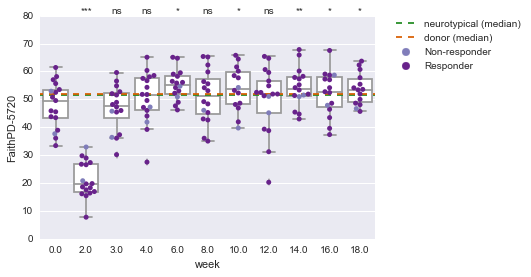

In [7]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab', metric='FaithPD-5720', hue='responder')

## Change with time: stool

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


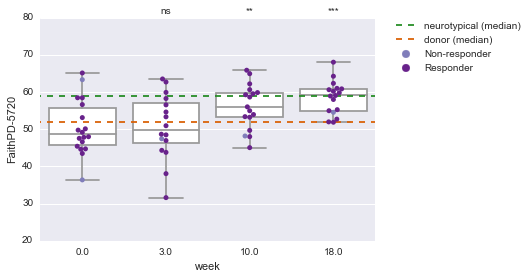

In [8]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
               metric='FaithPD-5720', hue='responder')

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


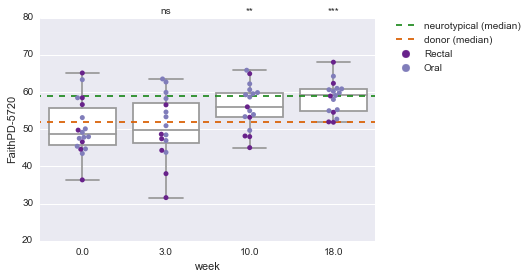

In [9]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
               metric='FaithPD-5720', hue='rectal_oral')

In [10]:
asd.tabulate_week_to_week0_paired_stats(sample_md, sample_type='stool',
                                    metric='FaithPD-5720')

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


,n,FaithPD-5720,t,p-value
week,,,,
0,0,NaN,NaN,NaN
3,16,-0.097726,0.265153,0.794501
10,17,6.723707,3.266565,0.004849
18,17,9.576559,5.635941,0.000037


In [11]:
asd.tabulate_week_to_control_stats(sample_md, sample_type='stool',
                               metric='FaithPD-5720')

,n,FaithPD-5720,t,p-value
week,,,,
0,18,48.580970,-2.557368,0.014845
3,16,49.796581,-2.277617,0.029150
10,17,56.008871,-0.565709,0.575320
18,17,59.069233,0.394351,0.696193


## Engraftment: Swab

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


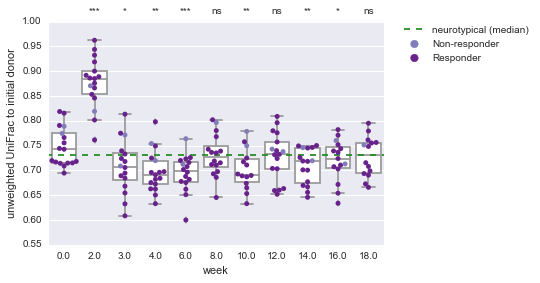

In [12]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab',
                          metric='unweighted UniFrac to initial donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


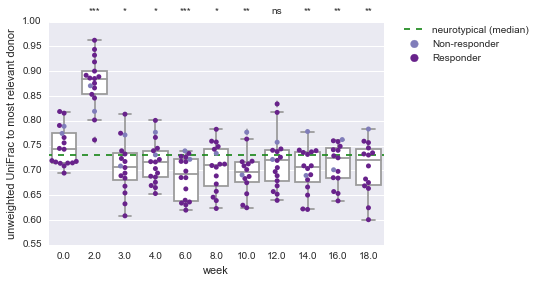

In [13]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab',
                          metric='unweighted UniFrac to most relevant donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


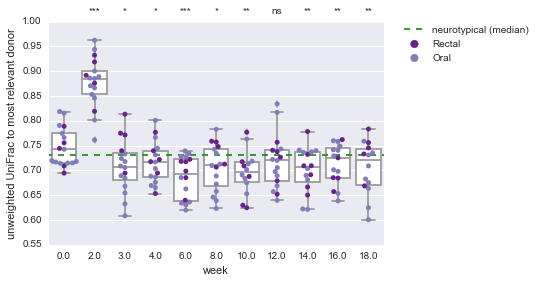

In [14]:
asd.plot_week_data_with_stats(sample_md, sample_type='swab',
                          metric='unweighted UniFrac to most relevant donor', hue='rectal_oral', one_tailed=True,
                          hide_donor_baseline=True)

## Engraftment: stool

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


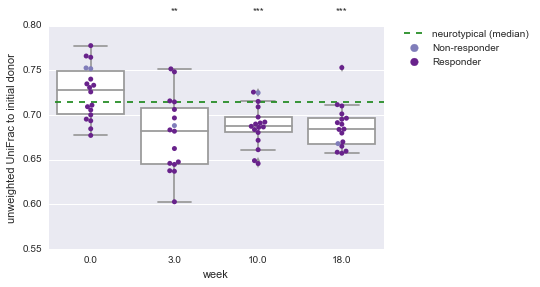

In [15]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
                          metric='unweighted UniFrac to initial donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


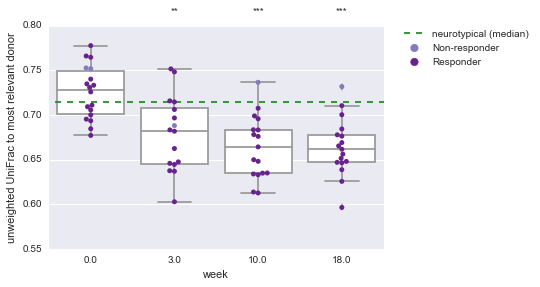

In [16]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
                          metric='unweighted UniFrac to most relevant donor', hue='responder', one_tailed=True,
                          hide_donor_baseline=True)

/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/caporaso/miniconda3/envs/q2d2/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


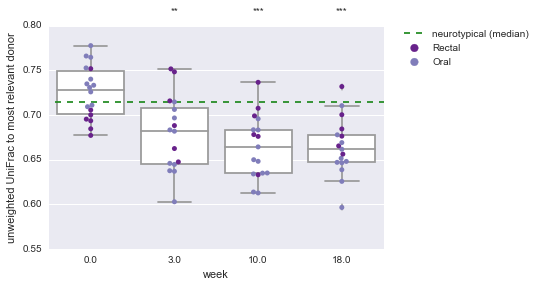

In [17]:
asd.plot_week_data_with_stats(sample_md, sample_type='stool',
                          metric='unweighted UniFrac to most relevant donor', hue='rectal_oral', one_tailed=True,
                          hide_donor_baseline=True)